# Import libs

In [ ]:
import re
import seaborn as sns
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pickle
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib import rcParams

tqdm.pandas()

sns.set_theme()
rcParams['figure.figsize'] = 15,8

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [ ]:
!pip install vncorenlp

# Git clone

In [ ]:
# Clone the entire repo.
!git clone https://github.com/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-.git
%cd Vietnamese-Reactionary-Article-Classification-/
!ls

fatal: destination path 'Vietnamese-Reactionary-Article-Classification-' already exists and is not an empty directory.
/content/Vietnamese-Reactionary-Article-Classification-
analysis  data	demo  modeling	README.md


# Read pickles

In [ ]:
%cd data/preprocessed/
! wget 'https://github.com/vncorenlp/VnCoreNLP/archive/v1.1.1.zip' -O ./models.$$ && unzip -o ./models.$$ && rm -r ./models.$$.

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
--2021-06-23 09:18:40--  https://github.com/vncorenlp/VnCoreNLP/archive/v1.1.1.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vncorenlp/VnCoreNLP/zip/v1.1.1 [following]
--2021-06-23 09:18:40--  https://codeload.github.com/vncorenlp/VnCoreNLP/zip/v1.1.1
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘./models.1211’

./models.1211           [         <=>        ] 137.29M  23.5MB/s    in 5.9s    

2021-06-23 09:18:46 (23.5 MB/s) - ‘./models.1211’ saved [143955573]

Archive:  ./models.1211
3b5c2aac53bb1fda0502d89ab8085b712e299fab
  inflating: VnCoreNLP

In [ ]:
def read_all_pickles(dir):
    ls_df = []
    for data in os.listdir(dir):
        print(data)
        with open(dir + data, "rb") as f:
            df = pickle.load(f)
            print("\n\n", df.head(), "\n\n")
            ls_df.append(df)

    final_df = pd.concat(ls_df)
    final_df.drop_duplicates('content', inplace = True)
    return final_df

df_1 = read_all_pickles('./1/')
df_0 = read_all_pickles('./0/')

df = pd.concat([df_1, df_0])

giaochucchuvanan.pickle


                                               content  label  avg_length
1   THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?\n\nKhoảng Trờ...      1         644
2   Nguyễn Đình Cống\n3 giờ ·\nTHƯ TRẢ LỜI CỦA BỘ ...      1        1384
20  KHÔNG BIẾT NHỤC SAO CÒN TỰ HÀO?\n\nĐảng csVn đ...      1        2015
28  \nTUOITRE.VN\nHàng ngàn người tiễn biệt cố Thứ...      1         834
29  Lý thuyết cai trị dân bằng bạo lực "cách mạng"...      1         501 


thanhnienconggiao.pickle


                                              content  label  avg_length
0  “Nếu linh hồn thuộc về nhà nước, thì việc dâng...      1         625
1  MUỐN VÀO NƯỚC TRỜI HÃY NÊN NHƯ TRẺ NHỎ\n\nLòng...      1         700
2  MƯỜI CĂN BỆNH LÀM BĂNG HOẠI NGƯỜI CÔNG GIÁO\n(...      1         703
3  BẢN TIN ĐẶC BIỆT VỀ NỮ TÙ NHÂN LƯƠNG TÂM VIỆT ...      1         702
4  Bộ máy nhà nước Việt Nam hiện tại có khoảng 3 ...      1         703 


viettan.pickle


                                              conten

In [ ]:
df = df[df['avg_length'] < 20000]

# Remove abbreviation + teencode

## Read and write pickle function

In [ ]:
def write_pickle(df, dir):
    with open(dir, 'wb') as handle:
        pickle.dump(df, handle)
    return
    
def read_pickle(dir):
    with open(dir, 'rb') as fs:
        df = pickle.load(fs)
    return df

## Read csv

In [ ]:
abbreviation = pd.read_csv('./resources/abbreviation.csv')
abbreviation = abbreviation[['viet tat_x', 'mean']]
abbreviation.head()

,viet tat_x,mean
0,ABC,Công ty Truyền thông ABC
1,ADB,Ngân hàng Phát triển châu Á
2,ADN,AND
3,ANĐT,an ninh điều tra
4,ATGT,An toàn Giao thông


## Add them tu khoa

In [ ]:
abbreviation = dict(zip(abbreviation['viet tat_x'], abbreviation['mean']))

abbreviation['csvn'] = 'Cộng sản Việt Nam'
abbreviation['đcsvn'] = 'Đảng Cộng sản Việt Nam'
abbreviation['xhcn'] = 'Xã hội Chủ nghĩa'
abbreviation['cntb'] = 'Chủ nghĩa Tư bản'
abbreviation['cs'] = 'Cộng sản'

## Replace key - value

In [ ]:
def replace_non_case(df):
    count = 0
    for pat, repl in abbreviation.items():
        df['content'] = df['content'].str.replace(pat, repl, case = False, regex = False)
        
        # Progress printing
        if count % 10 == 0:
            print(f"count: {count}")
        count += 1
    

    return df

temp = df.copy()
temp = replace_non_case(temp)

count: 0
count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 70
count: 80
count: 90
count: 100
count: 110
count: 120
count: 130
count: 140
count: 150
count: 160
count: 170
count: 180
count: 190
count: 200
count: 210
count: 220
count: 230
count: 240
count: 250
count: 260
count: 270
count: 280
count: 290
count: 300
count: 310
count: 320
count: 330
count: 340
count: 350
count: 360
count: 370
count: 380
count: 390
count: 400
count: 410
count: 420
count: 430
count: 440
count: 450
count: 460
count: 470
count: 480
count: 490
count: 500
count: 510
count: 520
count: 530
count: 540
count: 550
count: 560
count: 570
count: 580
count: 590
count: 600
count: 610
count: 620
count: 630
count: 640
count: 650
count: 660
count: 670
count: 680
count: 690
count: 700
count: 710
count: 720
count: 730
count: 740
count: 750
count: 760
count: 770
count: 780
count: 790
count: 800
count: 810
count: 820
count: 830


## Số dòng được thay thế từ viết tắt

In [ ]:
sum(temp['content'] != df['content'])

14536

## Save as pickle

In [ ]:
# df = temp
write_pickle(temp, './resources/df_abv.pickle')

In [ ]:
df = temp

# Word segmentation

In [ ]:
from vncorenlp import VnCoreNLP

VNCOR = './VnCoreNLP-1.1.1/VnCoreNLP-1.1.1.jar'
segmenter = VnCoreNLP(VNCOR, annotators= 'wseg')

In [ ]:
# txt = 'học sinh học sinh học'
# print(segmenter.tokenize(txt))



def sen_word_seg(sample):
    """ Viblo - phoBERT """
    
    splits = sample.strip().split('\n')
    text = ' '.join(splits)

    # return
    text = segmenter.tokenize(text)
    text = ' '.join([' '.join(x) for x in text])
    
    return text





sen_word_seg('hôm nay tôi đi học.\n Có cái buồi gì đâu')

hôm_nay tôi đi học . Có cái buồi gì đâu


#Count plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



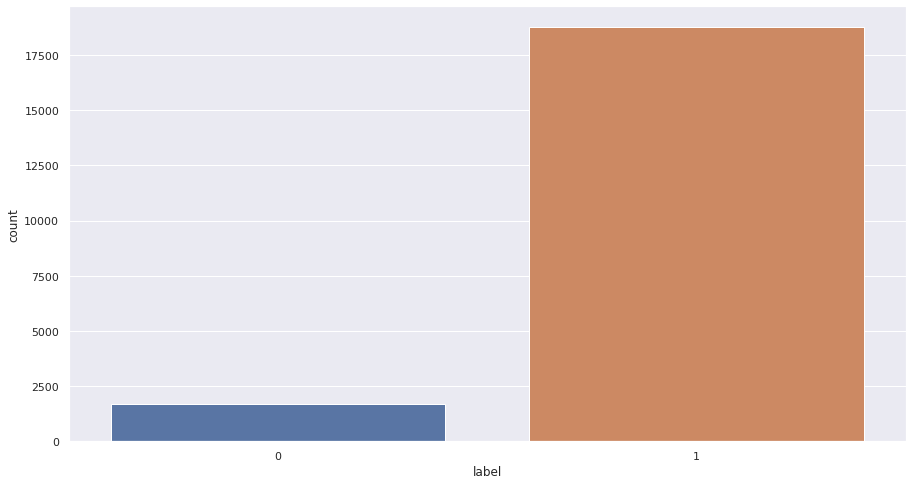

In [ ]:
sns.countplot(df['label'])

# Distribution of length

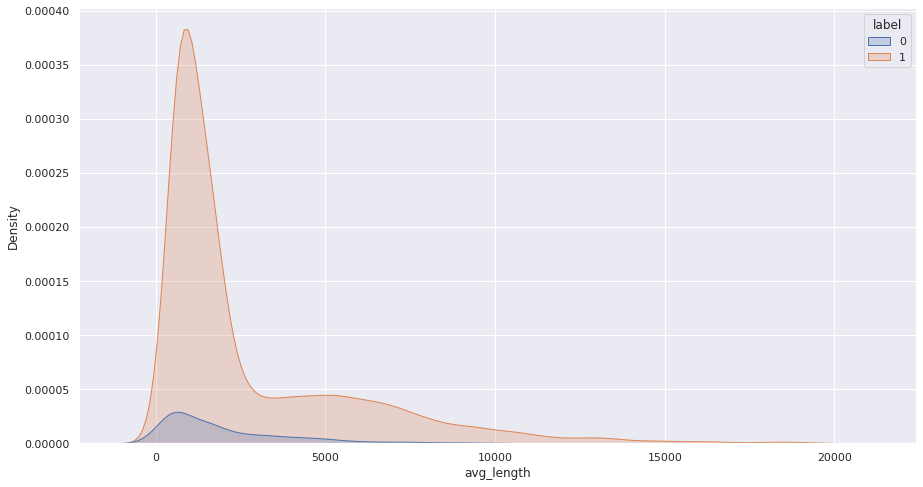

In [ ]:
sns.kdeplot(df['avg_length'], fill = True, hue = df['label'])

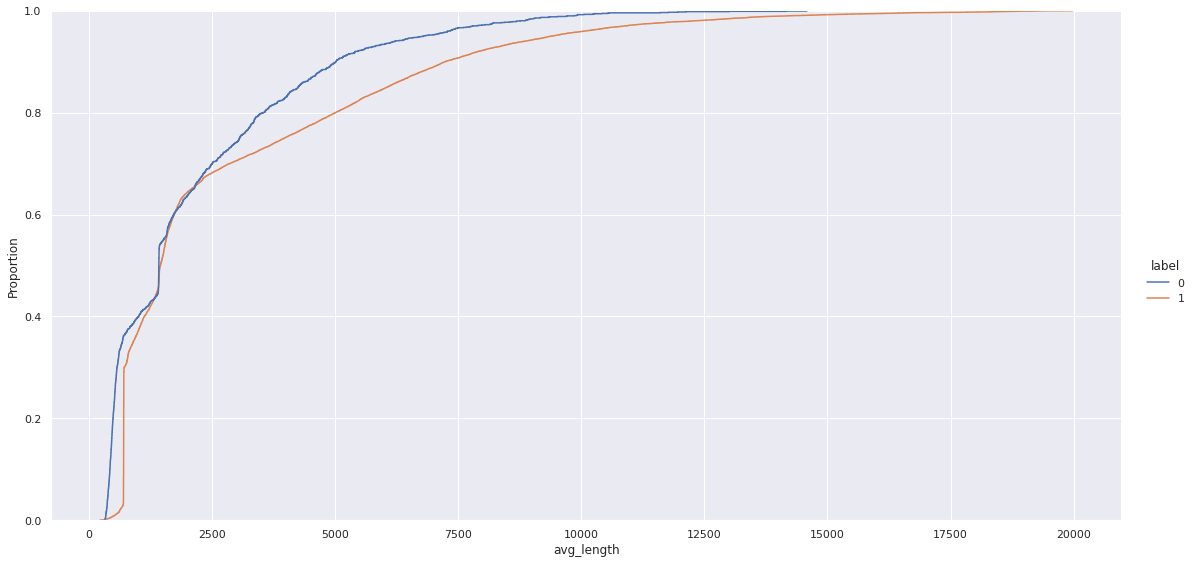

In [ ]:
sns.displot(df, x="avg_length", kind="ecdf", height= 8, aspect = 2, hue = 'label')